A more precise example of VQE on $\text H_2$ with 4 qubits.

In [1]:
using Yao
using YaoExtensions
using PyCall

Here we we invoke [OpenFermion](https://github.com/quantumlib/OpenFermion) in Python to get the Hamiltonian under Jordan-Weigner transformation (with 2 electrons and 4 sto-3g basis set orbitals).

In [8]:
py"""
import numpy as np
from openfermion.config import *
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import jordan_wigner

def make_H2_mol(bond_len):
    
    # Returns:
    #     molecule(openfermion.hamiltonians.MolecularData):
    # MolecularData for H2 with certain bond length
    
    # Load molecule
    atom_1 = 'H'
    atom_2 = 'H'
    basis = 'sto-3g'
    multiplicity = 1
    charge = 0
    coordinate_1 = (0.0, 0.0, 0.0)
    coordinate_2 = (0.0, 0.0, bond_len)
    geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]
    molecule = MolecularData(geometry, basis, multiplicity,
    charge, description=str(bond_len))
    #molecule = run_pyscf(molecule,run_scf=1,run_ccsd=1,run_fci=1)
    # Because the package openfermionpyscf is available, 
    # only existing molecule data can be used
    molecule.load()
    return molecule

def get_hamiltonian(bond_len):
    # get the coefficients and pauli terms of Hamiltonian of H_2 with given bond length
    # Returns:
    #     (PyArray,PyArray)
    molecule = make_H2_mol(bond_len)
    qubit_hamiltonian = jordan_wigner(molecule.get_molecular_hamiltonian())
    qubit_hamiltonian.compress()
    return list(qubit_hamiltonian.terms.keys()),list(qubit_hamiltonian.terms.values())

"""

A function to transfer OpenFermion Hamiltonian to Yao circuit.

In [9]:
function get_fermion_hamiltonian(n::Int,terms::Array,coefs::Vector)
    gates=Dict("Z"=>Z,"X"=>X,"Y"=>Y)
    to_pauli(t::Tuple{Int,String})=put(n,t[1]+1=>get(gates,t[2],ErrorException("Invalid")))
    return sum(coefs[2:end].*map(x->reduce(*,map(to_pauli,x)),terms[2:end]))
end

get_fermion_hamiltonian (generic function with 1 method)

use VQE code given in the previous Yao example

In [10]:
using Flux: Optimise

function train!(circ, hamiltonian; optimizer, niter::Int=200,verbose::Bool=true)
     params = parameters(circ)
     dispatch!(circ, :random)
     for i=1:niter
         _, grad = expect'(hamiltonian, zero_state(nqubits(circ)) => circ)
         Optimise.update!(optimizer, params, grad)
         dispatch!(circ, params)
         if verbose
            println("Energy = 
            $(expect(hamiltonian, zero_state(nqubits(hamiltonian)) |> circ) |> real)")
         end
     end
     return expect(hamiltonian, zero_state(nqubits(hamiltonian)) |> circ)
end

train! (generic function with 1 method)

train VQE to search ground energy on various bond lengths

In [29]:
# pushfirst!(PyVector(pyimport("sys")."path"), "")
# gen_h= pyimport("hamiltonian")
# you can put the Python code in another file and import as pymodule 

bond_lens = Array(0.2:0.1:1.5)#\AA
pes = Vector{Real}()


for l in bond_lens
    terms, coefs = py"get_hamiltonian"(l)
    e = coefs[1]
    
    
    h = get_fermion_hamiltonian(4,terms,coefs)
    c = variational_circuit(4)
    emin_vqe = train!(c, h; optimizer=Optimise.ADAM(0.1),verbose=false)
    println("Estimated minimum energy at bond length $(l): $(e+emin_vqe|>real)")
    push!(pes,e+emin_vqe|>real)
    
    using LinearAlgebra
    emin = eigvals(Matrix(mat(h)))[1]
    @assert isapprox(emin, emin_vqe, atol=1e-2)
end 

Estimated minimum energy at bond length 0.2: 0.15749901441533343
Estimated minimum energy at bond length 0.3: -0.6018014720306364
Estimated minimum energy at bond length 0.4: -0.9140871323887342
Estimated minimum energy at bond length 0.5: -1.0551147701526715
Estimated minimum energy at bond length 0.6: -1.1162858716864366
Estimated minimum energy at bond length 0.7: -1.136186260989544
Estimated minimum energy at bond length 0.8: -1.1341210588160164
Estimated minimum energy at bond length 0.9: -1.1204863159859424
Estimated minimum energy at bond length 1.0: -1.1011503265466471
Estimated minimum energy at bond length 1.1: -1.0791929374354472
Estimated minimum energy at bond length 1.2: -1.0567400536632738
Estimated minimum energy at bond length 1.3: -1.0351358811867624
Estimated minimum energy at bond length 1.4: -1.0154678091649882
Estimated minimum energy at bond length 1.5: -0.9981488826187901


plot the potential energy surface (PES)

In [56]:
using Plots

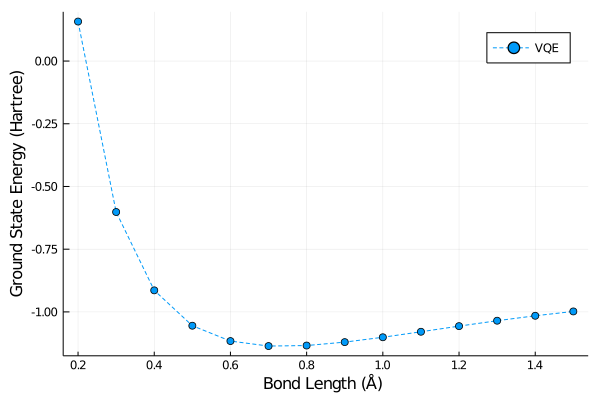

In [60]:
plot(bond_lens,pes, markershape = :circle, linestyle = :dash, label = "VQE",ylabel = "Ground State Energy (Hartree)", xlabel = "Bond Length (Å) ")

the bond length given by FCI (Full Configuration Interaction) is -1.13730688  Hartree at 0.734832 Å